In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
from lion_pytorch import Lion
from datetime import datetime
import random

In [17]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [18]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            initial_theta = calculate_initial_theta(segment,original_image_size,position)
            # initial_theta = get_random_initial_position(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        self.static_coordinates = torch.tensor(initial_vector)
        print(self.coordinates)
        # self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        self.background_color = torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float)
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]
            if n == 6:
                theta_tensor[0][0][2]+=self.coordinates[n][0]
                theta_tensor[0][1][2]+=self.coordinates[n][1]
            else:
                theta_tensor[0][0][2]+=self.static_coordinates[n][0]
                theta_tensor[0][1][2]+=self.static_coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

In [23]:
msUIo_wbg_gr = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


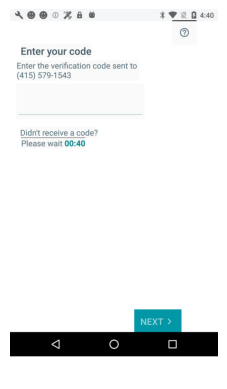

In [24]:
canvasses = msUIo_wbg_gr()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))

plt.axis('off')
plt.show()

In [25]:
def get_random_initial_position(segment, canvas_size, original_position, seed=1):
    # random.seed(seed)

    
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    
    mapped_x_position = random.uniform(-(x_ratio-1), (x_ratio-1))
    mapped_y_position = random.uniform(-(y_ratio-1), (y_ratio-1))

    print(f"Original would have been: {calculate_initial_theta(segment,canvas_size,original_position)}")
    print(f"""Now is {np.array([ 
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])}""")

    
    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])

In [26]:
appsthetics_predictor = torch.load("./resnet_50_20_epochs_2024-05-13T14:03")

In [27]:
appsthetics_predictor.eval()
1

1

In [31]:
scores = []
images_for_gif = []
optimizer = torch.optim.AdamW(msUIo_wbg_gr.parameters(), lr=0.5)
for x in tqdm.tqdm(range(200)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg_gr()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    # Convert to grayscale
    new_image = (generated_image[0]*0.299+generated_image[1]*0.587+generated_image[2]*0.114)
    rgb_grayscale_im = torch.stack([new_image,new_image,new_image])

    #score = appsthetics_predictor(generated_image.unsqueeze(0))
    score = appsthetics_predictor(rgb_grayscale_im.unsqueeze(0))
    print(score)

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    #pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = transform_t_to_pil(rgb_grayscale_im.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|                                                                                                                                                                                                        | 0/200 [00:00<?, ?it/s]

tensor([[0.2582]], grad_fn=<AddmmBackward0>)


  0%|▉                                                                                                                                                                                               | 1/200 [00:15<51:08, 15.42s/it]

tensor([[0.2669]], grad_fn=<AddmmBackward0>)


  1%|█▉                                                                                                                                                                                              | 2/200 [00:29<47:43, 14.46s/it]

tensor([[0.2639]], grad_fn=<AddmmBackward0>)


  2%|██▉                                                                                                                                                                                             | 3/200 [00:40<42:43, 13.01s/it]

tensor([[0.2668]], grad_fn=<AddmmBackward0>)


  2%|███▊                                                                                                                                                                                            | 4/200 [00:52<41:30, 12.71s/it]

tensor([[0.2590]], grad_fn=<AddmmBackward0>)


  2%|████▊                                                                                                                                                                                           | 5/200 [01:03<39:10, 12.05s/it]

tensor([[0.2559]], grad_fn=<AddmmBackward0>)


  3%|█████▊                                                                                                                                                                                          | 6/200 [01:14<38:12, 11.81s/it]

tensor([[0.2601]], grad_fn=<AddmmBackward0>)


  4%|██████▋                                                                                                                                                                                         | 7/200 [01:27<38:38, 12.01s/it]

tensor([[0.2603]], grad_fn=<AddmmBackward0>)


  4%|███████▋                                                                                                                                                                                        | 8/200 [01:38<37:34, 11.74s/it]

tensor([[0.2618]], grad_fn=<AddmmBackward0>)


  4%|████████▋                                                                                                                                                                                       | 9/200 [01:49<36:55, 11.60s/it]

tensor([[0.2518]], grad_fn=<AddmmBackward0>)


  5%|█████████▌                                                                                                                                                                                     | 10/200 [02:01<36:35, 11.55s/it]

tensor([[0.2567]], grad_fn=<AddmmBackward0>)


  6%|██████████▌                                                                                                                                                                                    | 11/200 [02:13<37:23, 11.87s/it]

tensor([[0.2571]], grad_fn=<AddmmBackward0>)


  6%|███████████▍                                                                                                                                                                                   | 12/200 [02:28<39:51, 12.72s/it]

tensor([[0.2581]], grad_fn=<AddmmBackward0>)


  6%|████████████▍                                                                                                                                                                                  | 13/200 [02:40<38:59, 12.51s/it]

tensor([[0.2558]], grad_fn=<AddmmBackward0>)


  7%|█████████████▎                                                                                                                                                                                 | 14/200 [02:54<39:57, 12.89s/it]

tensor([[0.2546]], grad_fn=<AddmmBackward0>)


  8%|██████████████▎                                                                                                                                                                                | 15/200 [03:10<42:28, 13.77s/it]

tensor([[0.2590]], grad_fn=<AddmmBackward0>)


  8%|███████████████▎                                                                                                                                                                               | 16/200 [03:26<44:11, 14.41s/it]

tensor([[0.2589]], grad_fn=<AddmmBackward0>)


  8%|████████████████▏                                                                                                                                                                              | 17/200 [03:40<44:13, 14.50s/it]

tensor([[0.2542]], grad_fn=<AddmmBackward0>)


  9%|█████████████████▏                                                                                                                                                                             | 18/200 [03:55<44:34, 14.69s/it]

tensor([[0.2548]], grad_fn=<AddmmBackward0>)


 10%|██████████████████▏                                                                                                                                                                            | 19/200 [04:08<42:10, 13.98s/it]

tensor([[0.2557]], grad_fn=<AddmmBackward0>)


 10%|███████████████████                                                                                                                                                                            | 20/200 [04:19<39:04, 13.03s/it]

tensor([[0.2538]], grad_fn=<AddmmBackward0>)


 10%|████████████████████                                                                                                                                                                           | 21/200 [04:30<37:37, 12.61s/it]

tensor([[0.2537]], grad_fn=<AddmmBackward0>)


 11%|█████████████████████                                                                                                                                                                          | 22/200 [04:43<37:25, 12.62s/it]

tensor([[0.2505]], grad_fn=<AddmmBackward0>)


 11%|█████████████████████                                                                                                                                                                          | 22/200 [04:57<40:04, 13.51s/it]


KeyboardInterrupt: 

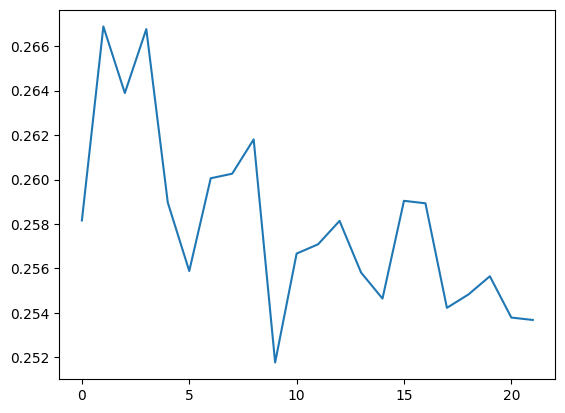

In [32]:
plt.plot(scores)
plt.show()

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_29929/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_29929/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



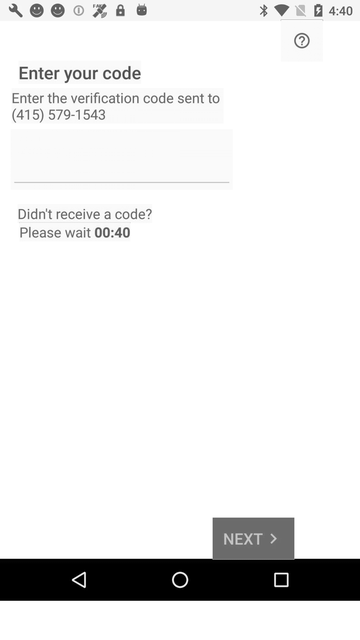

In [33]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))